# Zeta Disease Analysis

Mars Mission Control needs a good data-driven system for predicting Zeta Disease infection on the International Mars Colony.
This project uses the `_zeta-disease_training-data_` dataset to build a model that can predict who will be infected by Zeta Disease.

The dataset includes 9 columns with information on 800 people.
1.	age : in years
2.	weight : body weight in pounds (lbs)
3.	bmi : Body Mass Index (weight in kg/(height in m)2)
4.	blood_pressure : resting blood pressure (mm Hg)
5.	insulin_test : inuslin test value
6.	liver_stress_test : liver_stress_test value
7.	cardio_stress_test : cardio_stress_test value
8.	years_smoking : number of years of smoking
9. zeta_disease :
              1 = yes;
              0 = no

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Data Exploration

In [14]:
file_path = "Data/recruiting_zeta-disease_training-data_take-home-challenge.xlsx"
df = pd.read_excel(file_path)

df.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [15]:
print(df.dtypes)

age                     int64
weight                  int64
bmi                   float64
blood_pressure          int64
insulin_test            int64
liver_stress_test     float64
cardio_stress_test      int64
years_smoking           int64
zeta_disease            int64
dtype: object


In [16]:
len(df)

800

In [17]:
descriptions = df.describe()
print(descriptions)

              age      weight         bmi  blood_pressure  insulin_test  \
count  800.000000  800.000000  800.000000      800.000000    800.000000   
mean    30.985000  172.407500   32.201625       69.565000     85.887500   
std     13.824025   31.942438    8.549155       19.874784    126.333656   
min     18.000000   94.000000    0.000000        0.000000      0.000000   
25%     21.000000  149.000000   27.300000       62.000000      0.000000   
50%     26.000000  167.000000   32.050000       72.000000     45.000000   
75%     38.000000  192.000000   36.525000       80.000000    130.000000   
max    109.000000  308.000000   86.100000      157.000000   1077.000000   

       liver_stress_test  cardio_stress_test  years_smoking  zeta_disease  
count         800.000000          800.000000     800.000000    800.000000  
mean            0.544496           43.121250       4.051250      0.348750  
std             0.348711           30.409949       4.176173      0.476873  
min             0.14

In [18]:
print(df.isnull().any())

age                   False
weight                False
bmi                   False
blood_pressure        False
insulin_test          False
liver_stress_test     False
cardio_stress_test    False
years_smoking         False
zeta_disease          False
dtype: bool



# Initial Data Exploration Insights

**Dataset Characteristics**: The dataset contains 800 rows with all columns being numeric. Some columns consist of whole numbers, while others contain decimal values.

**Potential Outliers**: Preliminary analysis suggests the presence of outliers based on data descriptions.

**No Missing Values**: There are no null values in the dataset, eliminating the need for imputation or deletion strategies for missing data.

# Plots:

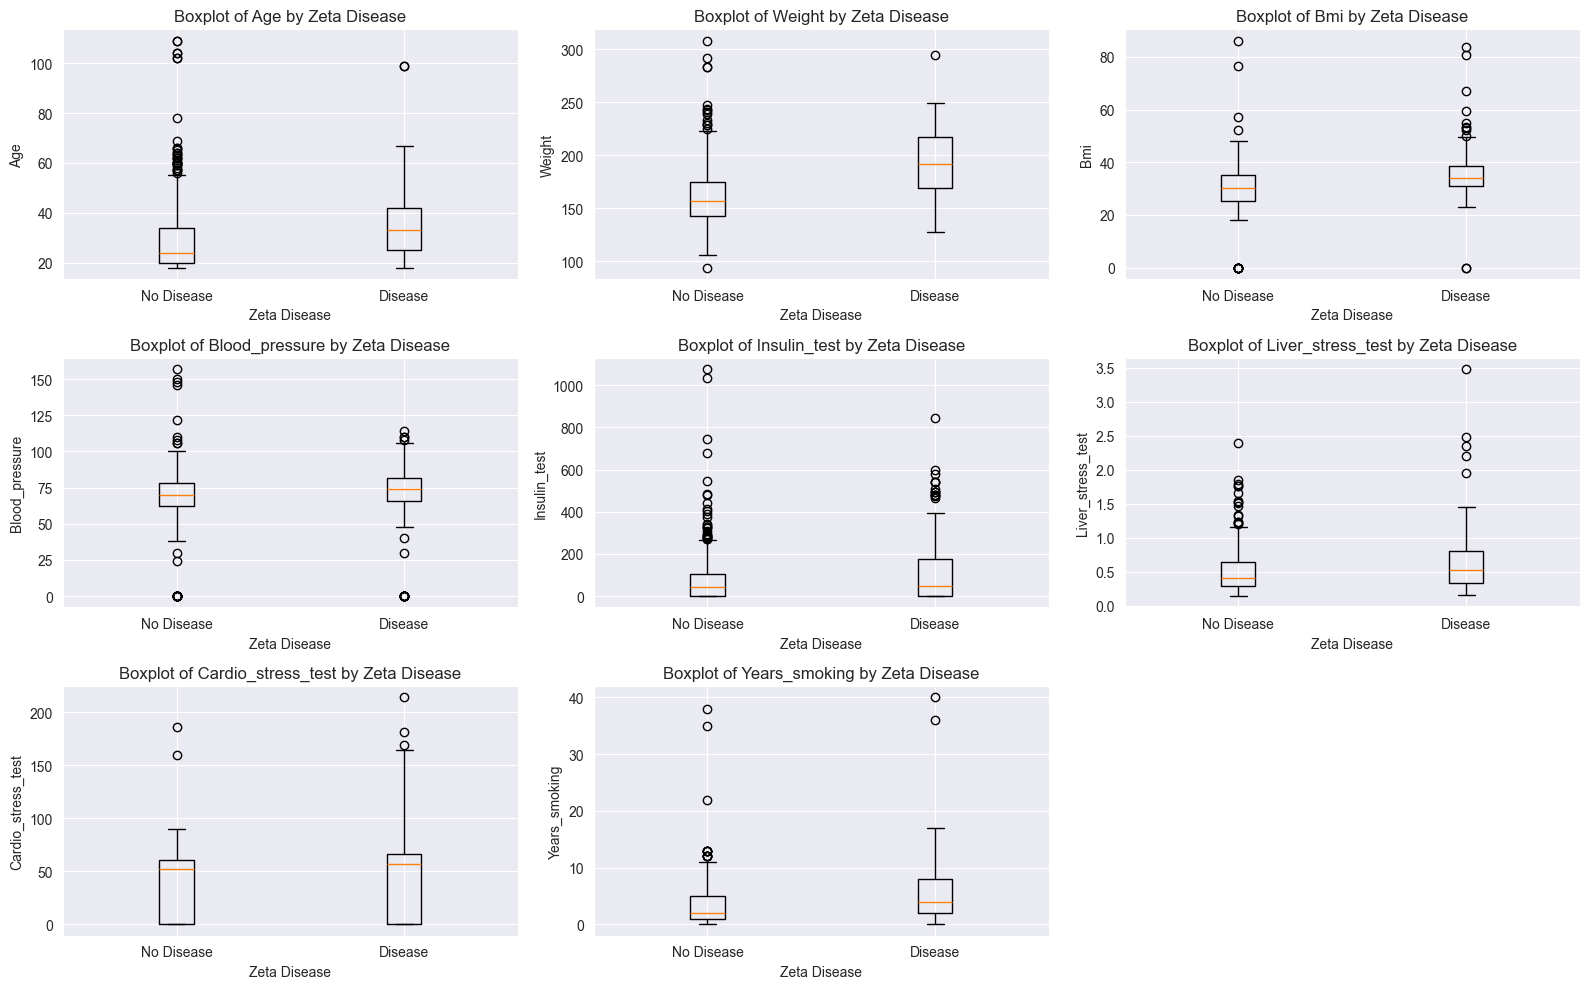

In [19]:
variables = ['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test', 'liver_stress_test', 'cardio_stress_test'
             , 'years_smoking']
plt.figure(figsize=(16, 10))
for i, variable in enumerate(variables, start=1):
    plt.subplot(3, 3, i)
    plt.boxplot([df[df['zeta_disease'] == 0][variable], df[df['zeta_disease'] == 1][variable]])
    plt.title(f'Boxplot of {variable.capitalize()} by Zeta Disease')
    plt.xlabel('Zeta Disease')
    plt.ylabel(variable.capitalize())
    plt.xticks([1, 2], ['No Disease', 'Disease'])
    plt.grid(True)

plt.tight_layout()
plt.show()


The median values for both Disease and No Disease appear similar across most variables. In contrast, Weight is notable as it shows the most pronounced difference in medians, suggesting its potential as a significant predictor. The data suggests that individuals with higher weight may be at a heightened risk of developing the disease. Additionally, there are noticeable outliers present, indicating the need for outlier treatment in our analysis.

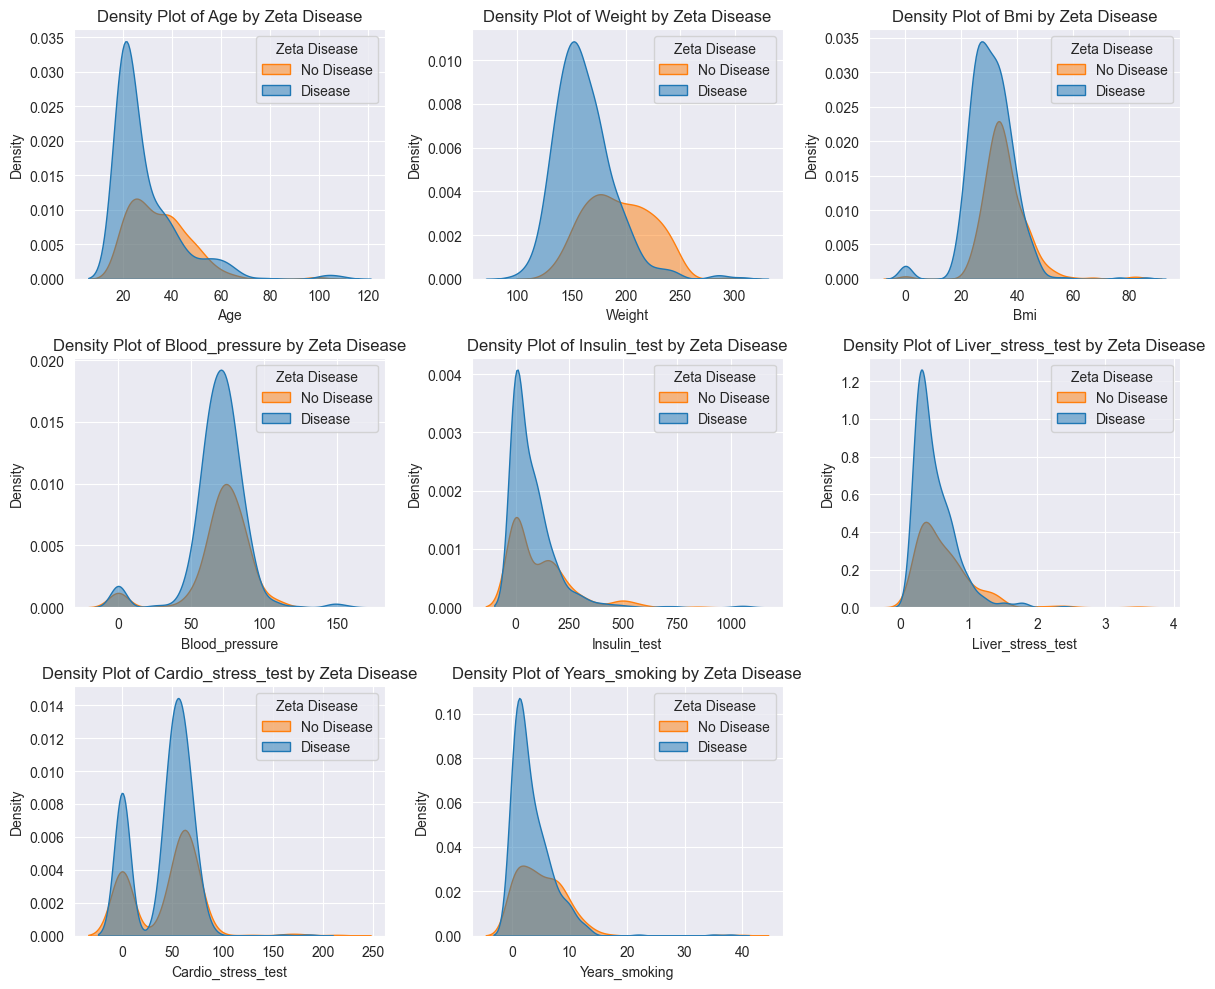

In [20]:
plt.figure(figsize=(12, 10))
# now plot the above but as a density plot
for i, variable in enumerate(variables, start=1):
    plt.subplot(3, 3, i)
    sns.kdeplot(data=df, x=variable, hue='zeta_disease', fill=True, alpha=0.5)
    plt.title(f'Density Plot of {variable.capitalize()} by Zeta Disease')
    plt.xlabel(variable.capitalize())
    plt.ylabel('Density')
    plt.legend(title='Zeta Disease', labels=['No Disease', 'Disease'])
    plt.grid(True)

plt.tight_layout()
plt.show()

The density plot again shows weight as being notably distinct. Additionally, other variables such as age and liver stress test exhibit subtle differences. 

Next, I'll generate a correlation matrix. It's important to assess multicollinearity, as certain models such as logistic regression can be adversely affected by it.

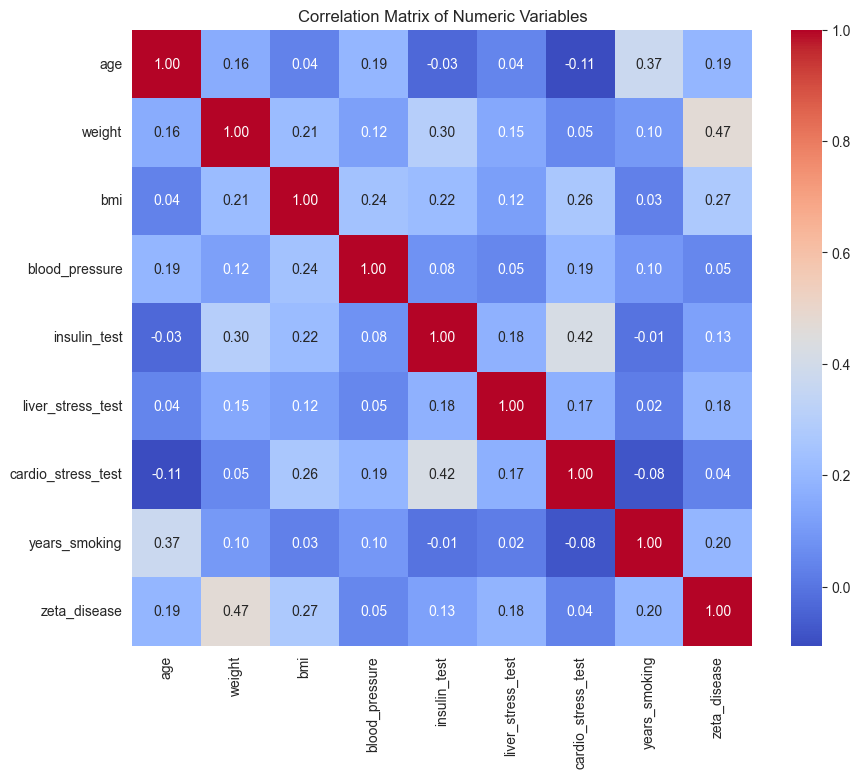

In [21]:
# plot a correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

Unexpectedly, there is no indication of multi collinearity. This is surprising as we would expect weight and bmi to be highly correlated as weight is used in BMI calculations.

Lastly, we'll examine the proportions of disease versus no disease to determine if there's a need for data rebalancing.

In [22]:
percentages = df['zeta_disease'].value_counts(normalize = True) * 100
print(percentages)

zeta_disease
0    65.125
1    34.875
Name: proportion, dtype: float64


65% of the dataset does not have the disease, 35% does. It does not need rebalancing.

# Data prep for modeling

First, I will split the data into train and test sets for model building. It's important to verify that both sets exhibit a balanced distribution of "Yes" and "No" disease cases.

Next, I will scale the data. This step is crucial for the K-Nearest Neighbors model we will be testing, as scaling helps ensure that the results are not skewed.

Finally, I will detect outliers and remove them.

In [23]:
# split data into train and test
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)
print('Train df Shape:', train_df.shape, 'Test df shape:', test_df.shape)

Train df Shape: (600, 9) Test df shape: (200, 9)


In [24]:
# now calculate the proportions for each
train_proportions = train_df['zeta_disease'].value_counts(normalize=True) * 100
test_proportions = test_df['zeta_disease'].value_counts(normalize=True) * 100

print(train_proportions, test_proportions)

zeta_disease
0    64.5
1    35.5
Name: proportion, dtype: float64 zeta_disease
0    67.0
1    33.0
Name: proportion, dtype: float64


The proportions of yes disease and no disease look good, so we move on to scaling and removing outliers.

In [25]:
# split the dfs now into x and y (x = features, y = target var (disease))
x_train_unscaled = train_df.drop('zeta_disease', axis = 1)
y_train = train_df['zeta_disease']

x_test_unscaled = test_df.drop('zeta_disease', axis = 1)
y_test = test_df['zeta_disease']

In [26]:
scaler = StandardScaler()

# transform both the training and testing data
x_train = scaler.fit_transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled)

In [27]:
def detect_outliers(data, threshold = 3):
    outliers_indices = []
    for i in range(data.shape[1]):  # Loop through each variable
        z_scores = np.abs(data[:, i])
        outliers = np.where(z_scores > threshold)[0]
        outliers_indices.extend(outliers)
    return np.unique(outliers_indices)

# Detect outliers in the scaled training data
outliers_train = detect_outliers(x_train)
print('Number of outliers in training data:', len(outliers_train))

Number of outliers in training data: 75


In [28]:
# remove outliers
x_train = np.delete(x_train, outliers_train, axis=0)
y_train = y_train.drop(train_df.index[outliers_train])

**Begin Modeling**

I will try four different models: logistic regression, K nearest neighbors, random forest, and XGBoost.

LOGISTIC REGRESSION

In [29]:
logit_mod = LogisticRegression()

# grid search
logit_param_grid = {'C': [.0001, .001, .01, .1, 1, 10, 100]}
logit_grid_search = GridSearchCV(estimator = logit_mod, param_grid = logit_param_grid, cv = 5, scoring = 'accuracy', verbose = 1)

logit_grid_search.fit(x_train, y_train)

logit_best_mod = logit_grid_search.best_estimator_
print(logit_best_mod) # looks like .001 is the best penalty

Fitting 5 folds for each of 7 candidates, totalling 35 fits
LogisticRegression(C=10)


In [30]:
logit_y_pred = logit_best_mod.predict(x_test)

# calculate results
logit_report = classification_report(y_test, logit_y_pred)
print(logit_report)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       134
           1       0.59      0.58      0.58        66

    accuracy                           0.73       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.73      0.73      0.73       200



In [31]:
cf_mat = confusion_matrix(y_test, logit_y_pred, labels = [0, 1])
print(cf_mat)

[[108  26]
 [ 28  38]]


**Logistic Regression Results:**

108/134 of people who were predicted to not get the disease and actually didn't were correctly classified.

38/66 of people who were predicted to get the disease and did were correctly classified.

28 with the disease but were predicted not to get the disease slipped through the cracks.

Because we are predicting something as important as a disease, it's important that the model is accurate and minimizes the number of false negatives. It is better to overpredict individuals getting the disease than predict they won't when they will. Therefore the metrics we will focus on are accuracy and recall/sensitivity. Recall measures the proportion of actual positive instances that were correctly identified by the model,

Recall in this instance is:

recall = 38 / (38 + 28) = .58

which can also be seen in the logit report printed above. Our goal with the next three models is to increase recall from .58 and increase accuracy from .73

K NEAREST NEIGHBORS

In [32]:
# Define the hyperparameters to tune
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 12, 15],  # list of values for the number of neighbors (k)
    'weights': ['uniform', 'distance'],  # weights assigned to neighbors ('uniform' or 'distance')
    'p': [1, 2],  # parameter for the Minkowski distance metric (1 for Manhattan distance, 2 for Euclidean distance)
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [3, 5, 7, 9, 12, 15, 30, 50]
}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(estimator = knn, param_grid = knn_param_grid, cv = 5, scoring = 'accuracy', verbose = 1)

knn_grid_search.fit(x_train, y_train)

best_knn = knn_grid_search.best_estimator_ # best model

best_knn_params = best_knn.get_params()
print(best_knn_params)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
{'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}


In [33]:
knn_y_pred = best_knn.predict(x_test)

# knn_acc = accuracy_score(y_test, knn_y_pred)
knn_report = classification_report(y_test, knn_y_pred)
# print(knn_acc)
print(knn_report)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       134
           1       0.62      0.59      0.60        66

    accuracy                           0.74       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.74      0.74      0.74       200



In [34]:
knn_cf_mat = confusion_matrix(y_test, knn_y_pred)
print(knn_cf_mat)

[[110  24]
 [ 27  39]]


KNN performed slightly better than logistic regression with recall = .59 and accuracy = .74

RANDOM FOREST

In [35]:
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200, 150, 300], # # of trees
    'max_depth': [3, 6, 10, 20], # max depth of trees
    'min_samples_split': [2, 4, 6, 8], # min required observations in any given node in order to split it
    'max_features': ['sqrt', 'log2', None], # num of features to consider when looking for the best split
}

rf = RandomForestClassifier(random_state=42)

rf_grid_search = GridSearchCV(estimator = rf, param_grid = rf_param_grid, cv = 5, scoring = 'accuracy', verbose = 1)

rf_grid_search.fit(x_train, y_train)

best_rf = rf_grid_search.best_estimator_

rf_best_params = rf_grid_search.best_params_
print(rf_best_params)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 100}


In [36]:
rf_y_pred = best_rf.predict(x_test)

rf_report = classification_report(y_test, rf_y_pred)
print(rf_report)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       134
           1       0.63      0.56      0.59        66

    accuracy                           0.74       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.74      0.74      0.74       200



In [37]:
rf_cf_mat = confusion_matrix(y_test, rf_y_pred)
print(rf_cf_mat)

[[112  22]
 [ 29  37]]


Random Forest performed slightly worse than KNN with a recall of .56. Accuracy, however, is the same at .74.

XGBOOST

In [38]:

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 7, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.15, 0.2, 0.25],
    'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1.0]
}

xgb_mod = xgb.XGBClassifier(objective = 'binary:logistic', random_state=42)

xgb_grid_search = GridSearchCV(estimator = xgb_mod, param_grid = xgb_param_grid, cv=5, scoring='accuracy', verbose=1)

xgb_grid_search.fit(x_train, y_train)

best_xgb = xgb_grid_search.best_estimator_

xgb_best_params = xgb_grid_search.best_params_
print(xgb_best_params)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
{'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.9}


In [39]:
xgb_y_pred = best_xgb.predict(x_test)

xgb_report = classification_report(y_test, xgb_y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       134
           1       0.60      0.62      0.61        66

    accuracy                           0.74       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.74      0.74      0.74       200



In [40]:
xgb_cf_mat = confusion_matrix(y_test, xgb_y_pred)
print(xgb_cf_mat)

[[107  27]
 [ 25  41]]


The accuracy of this XGBoost model matches our previous best model, KNN, with an accuracy of 0.74. However, its recall sees a significant boost to 0.62, making XGBoost our top choice.

Next, I will visualize the ROC/AUC curve, variable importance, and Shapley values for this model.

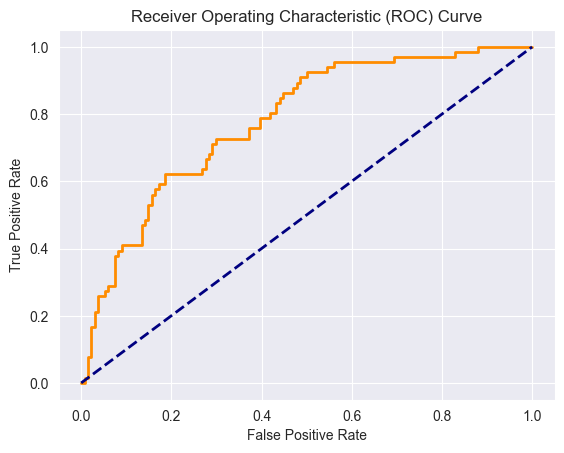

In [41]:
# first plot ROC curve
probs = best_xgb.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

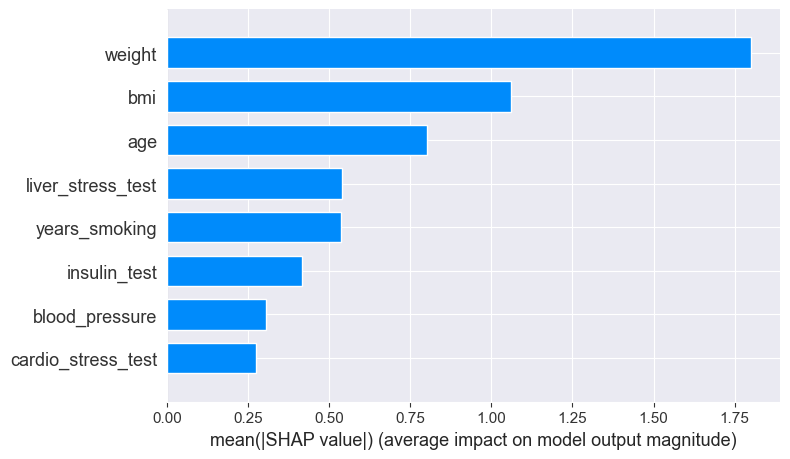

In [42]:
# variable importance

# add column names back in
feature_names = x_train_unscaled.columns
x_train_with_cols = pd.DataFrame(x_train, columns = feature_names)
x_test_with_cols = pd.DataFrame(x_test, columns = feature_names)

explainer = shap.Explainer(best_xgb, x_train_with_cols)

# Calculate SHAP values
shap_values = explainer.shap_values(x_test_with_cols)

shap.summary_plot(shap_values, x_test_with_cols, plot_type = "bar")


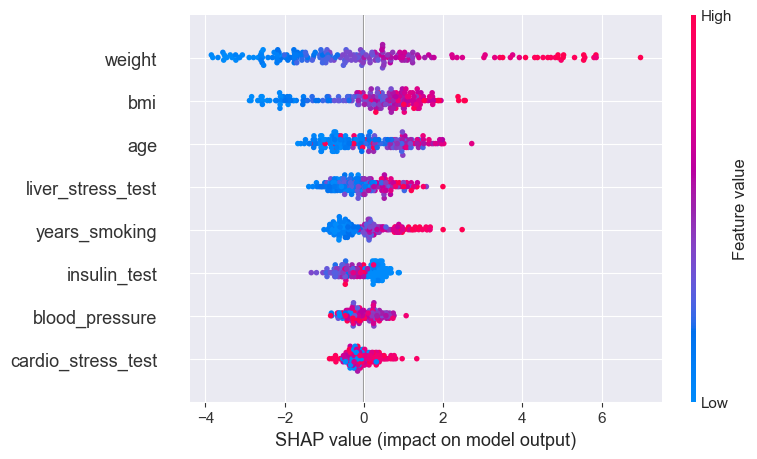

In [43]:
shap.summary_plot(shap_values, x_test_with_cols, plot_type = "dot")


Unsurprisingly, Weight is the most predictive of whether a person will get the zeta disease. BMI and Age follow as the next most predictive variables. 

# Read in final dataset to run best model and predict

Because XGBoost was the best model, we will now use the full training set to train and run an XGBoost model to predict new, unseen data.

In [4]:
# read in final testing data
file_path_preds = "Data/recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx"
final_test = pd.read_excel(file_path_preds)

# re-read in training data
file_path = "Data/recruiting_zeta-disease_training-data_take-home-challenge.xlsx"
final_train = pd.read_excel(file_path)

In [7]:
# prep the data
x_train_unscaled_final = final_train.drop('zeta_disease', axis = 1)
y_train_final = final_train['zeta_disease']

x_test_unscaled_final = final_test.drop('zeta_disease', axis = 1)

scaler_final = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
x_train_final = scaler_final.fit_transform(x_train_unscaled_final)
x_test_final = scaler_final.transform(x_test_unscaled_final)


In [9]:
# deal with outliers 
def detect_outliers_final(data, threshold = 3):
    outliers_indices = []
    for i in range(data.shape[1]):  # Loop through each variable
        z_scores = np.abs(data[:, i])
        outliers = np.where(z_scores > threshold)[0]
        outliers_indices.extend(outliers)
    return np.unique(outliers_indices)

# detect outliers in the scaled training data
outliers_train_final = detect_outliers_final(x_train_final)
print('Number of outliers in training data:', len(outliers_train_final))

Number of outliers in training data: 101


In [11]:
# final data prep step before final modeling: remove outliers
x_train_final = np.delete(x_train_final, outliers_train_final, axis=0)
y_train_final = y_train_final.drop(final_train.index[outliers_train_final])

In [12]:
# run best xgboost model
final_xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.9,
    learning_rate=0.15,
    max_depth=10,
    n_estimators=200,
    subsample=0.9
)

# Fit the model to the training data
final_xgb_model.fit(x_train_final, y_train_final)

# Predict on the test data
final_y_pred = final_xgb_model.predict(x_test_final)

In [13]:
print(final_y_pred)

[0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1]


**Recommendations for Future Enhancement:**
- Investigate the option of imputing outliers rather than outright removal. This could help preserve valuable data while still addressing data quality issues.
- Explore the possibility of expanding the dataset through the acquisition of additional rows or columns. This would likely enhance model performance significantly.
- Consider implementing variable bucketing instead of retaining them as numeric values (e.g., categorizing weight as high or low).
- Further refinement through extensive cross-validation, hyperparameter tuning, or experimentation with additional models could be explored, although marginal improvements may be expected.
- Evaluate the potential benefits of variable selection by removing variables that have minimal impact on classification accuracy.